In [5]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

import os
from functools import reduce

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

import sys
sys.path.append('..')
from src.evaluation import Evaluator, Plotter
from src.datasets import SyntheticDataGenerator, MultivariateAnomalyFunction
import main

c:\users\thomas\python\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TODO:
- XOR (Anomaly -> gleichzeitig)
- Ableitung (Geschwindigkeit vs Beschleunigung)
- Invers

## Plot missing results

In [ ]:
datasets = [SyntheticDataGenerator.get(f'extreme_1_missing', 42, missing) for missing in np.linspace(0, 0.9, 5)]
detectors = main.get_detectors()[:1] + main.get_detectors()[3:]

In [ ]:
detectors

In [ ]:
seeds = np.random.randint(low=0, high=2 ** 32 - 1, size=2, dtype="uint32")
results = pd.DataFrame()

for i, seed in enumerate(seeds):
    evaluator = Evaluator(datasets if datasets else get_pipeline_datasets(seed), detectors, seed=seed, output_dir='data')
    evaluator.evaluate()
    result = evaluator.benchmarks()
    evaluator.benchmark_results = result
    path = evaluator.export_results(f'missing-run-{i}-{seed}')
    del evaluator  # Save memory
    results = results.append(result, ignore_index=True)

### Read results from pickle

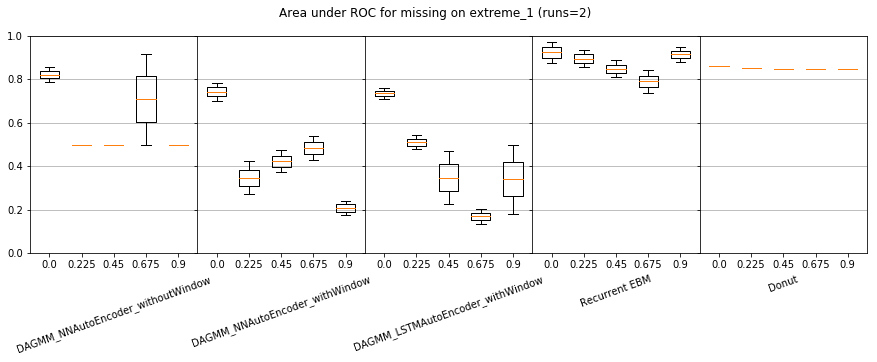

In [15]:
main.run_missing_experiment(outlier_type='extreme_1', runs=1, only_load=True, output_dir='data')

### Evaluate DAGMM

In [ ]:
datasets2 = [SyntheticDataGenerator.get(f'variance_1_missing', 100, 0)]
detectors2 = main.get_detectors()[3:4]
ev2 = Evaluator(datasets2, detectors2, output_dir=dir_)
ev2.evaluate()
result = ev2.benchmarks()
ev2.benchmark_results = result
# evaluator.export_results(f'missing-run-{i}-{seed}')

In [ ]:
ev2.plot_roc_curves()

In [ ]:
print(ev2.benchmark_results)
ev2.plot_scores(9)